In [446]:
# import libraries

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from collections import Counter
from collections import defaultdict
from collections import deque


In [447]:
# Set some options
np.set_printoptions(precision=3)
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [448]:
# define data and util functions

def marital_status_to_num(val):
    if val == 'M':
        return 0
    elif val == 'S':
        return 1
    elif val == 'D':
        return 2
    elif val == 'W':
        return 3
    else:
        return np.nan

def marital_status_to_str(val):
    if val == 0:
        return 'married'
    elif val == 1:
        return 'single'
    elif val == 2:
        return 'divorced'
    elif val == 3:
        return 'widowed'
    else:
        return np.nan

data_dict = {
    'data': {
        'rename': {
            'ID Number': 'id',
            'Lifetime HC': 'cum_donation',
            'Email Present': 'has_email',
            'BusPhone Present': 'has_business_phone',
            'Grad Year': 'grad_year',
            'Marital Status': 'marital_status',
            'SpouseID Present': 'has_spousal_record',
            'JobTitle Present': 'has_job_title',
            'VarsityAth Present': 'has_activity_athlete',
            'StudGovt Present': 'has_activity_government',
            'OtherStudActs Present': 'has_activity_other',
            'Greek Present': 'has_activity_greek',
            'Prefix is Mr.': 'is_mr',
            'Prefix is Ms.': 'is_ms',
            'Prefix is Dr.': 'is_dr',
            'Prefix is Mrs.': 'is_mrs'
        },
        'dtype': {
            'ID Number': str,
            'Lifetime HC': float,
            'Grad Year': int,
            'Marital Status': str
        }
    },
    'dummy': {
        'list': [
            'cum_range',
            'grad_decade',
            'imp_marital_status',
        ],
        'prefix': {
            'cum_range': 'bin_cum_range',
            'grad_decade': 'bin_grad_decade',
            'imp_marital_status': 'bin_imp_marital_status'
        },
        'giving': {
            'bins': [
                0.00,
                1.00,
                1000.00,
                10000.00,
                25000.00,
                50000.00,
                100000.00,
                250000.00,
                500000.00,
                1000000.00,
                2500000.00,
                5000000.00,
                10000000.00,
                15000000.00
            ],
            'labels': [
                '$0',
                '$1-$999.99',
                '$1K-$9.99K',
                '$10K-$24.99K',
                '$25K-$49.99K',
                '$50K-$99.99K',
                '$100K-$249.99K',
                '$250K-$499.99K',
                '$500K-$999.99K',
                '$1M-$2.49M',
                '$2.5M-$4.99M',
                '$5M-$9.99M',
                '$10M-$14.99M'
            ]
        },
        'grad': {
            'bins': [
                1900,
                1910,
                1920,
                1930,
                1940,
                1950,
                1960,
                1970,
                1980,
                1990,
                2000,
                2010,
                2020
            ],
            'labels': [
                '1900s',
                '1910s',
                '1920s',
                '1930s',
                '1940s',
                '1950s',
                '1960s',
                '1970s',
                '1980s',
                '1990s',
                '2000s',
                '2010s'
            ]
        }
    },
    'cols': {
        'bools': [
            'has_email',
            'has_business_phone',
            'has_spousal_record',
            'has_job_title',
            'has_activity_athlete',
            'has_activity_government',
            'has_activity_other',
            'has_activity_greek',
            'is_mr',
            'is_ms',
            'is_dr',
            'is_mrs',
            'has_donated'
        ],
        'bin_grad': [
            'bin_grad_decade_1900s',
            'bin_grad_decade_1910s',
            'bin_grad_decade_1920s',
            'bin_grad_decade_1930s',
            'bin_grad_decade_1940s',
            'bin_grad_decade_1950s',
            'bin_grad_decade_1960s',
            'bin_grad_decade_1970s',
            'bin_grad_decade_1980s',
            'bin_grad_decade_1990s',
            'bin_grad_decade_2000s',
            'bin_grad_decade_2010s'
        ],
        'bin_giving': [
            'bin_cum_range_$0',
            'bin_cum_range_$1-$999.99',
            'bin_cum_range_$1K-$9.99K',
            'bin_cum_range_$10K-$24.99K',
            'bin_cum_range_$25K-$49.99K',
            'bin_cum_range_$50K-$99.99K',
            'bin_cum_range_$100K-$249.99K',
            'bin_cum_range_$250K-$499.99K',
            'bin_cum_range_$500K-$999.99K',
            'bin_cum_range_$1M-$2.49M',
            'bin_cum_range_$2.5M-$4.99M',
            'bin_cum_range_$5M-$9.99M',
            'bin_cum_range_$10M-$14.99M'
        ],
        'bin_marital': [
            'bin_imp_marital_status_divorced',
            'bin_imp_marital_status_married',
            'bin_imp_marital_status_single',
            'bin_imp_marital_status_widowed'
        ],
        'log': [
            'has_donated'
        ],
        'lin': [
            'cum_donation'
        ],
        'all_cols': [
            'has_email',
            'has_business_phone',
            'has_spousal_record',
            'has_job_title',
            'has_activity_athlete',
            'has_activity_government',
            'has_activity_other',
            'has_activity_greek',
            'is_mr',
            'is_ms',
            'is_dr',
            'is_mrs',
            'has_donated',
            'grad_year',
            'cum_donation',
            'bin_grad_decade_1900s',
            'bin_grad_decade_1910s',
            'bin_grad_decade_1920s',
            'bin_grad_decade_1930s',
            'bin_grad_decade_1940s',
            'bin_grad_decade_1950s',
            'bin_grad_decade_1960s',
            'bin_grad_decade_1970s',
            'bin_grad_decade_1980s',
            'bin_grad_decade_1990s',
            'bin_grad_decade_2000s',
            'bin_grad_decade_2010s',
            'bin_cum_range_$0',
            'bin_cum_range_$1-$999.99',
            'bin_cum_range_$1K-$9.99K',
            'bin_cum_range_$10K-$24.99K',
            'bin_cum_range_$25K-$49.99K',
            'bin_cum_range_$50K-$99.99K',
            'bin_cum_range_$100K-$249.99K',
            'bin_cum_range_$250K-$499.99K',
            'bin_cum_range_$500K-$999.99K',
            'bin_cum_range_$1M-$2.49M',
            'bin_cum_range_$2.5M-$4.99M',
            'bin_cum_range_$5M-$9.99M',
            'bin_cum_range_$10M-$14.99M',
            'bin_imp_marital_status_divorced',
            'bin_imp_marital_status_married',
            'bin_imp_marital_status_single',
            'bin_imp_marital_status_widowed'
        ]
    }
}

In [449]:
def plot_roc_cur(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [450]:
project_dir = os.path.join(os.path.abspath(''),os.pardir)
data_dir = os.path.join(project_dir,'data')
data_raw_dir = os.path.join(data_dir,'raw')

file_list = []

for file in os.scandir(data_raw_dir):
    file_list.append(os.path.join(data_raw_dir,file.name))

df = pd.read_excel(io=file_list[0],
                   sheet_name='Sheet1',
                   dtype=data_dict['data']['dtype'])
df = df.rename(columns=data_dict['data']['rename'])
dre_df = df

/home/rob/.local/share/virtualenvs/assignment2-vA0J_QZc/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [451]:
# drop irrelevant columns
df = df.drop(columns='id')

In [452]:
# create a logistic column version of cum_donation_value called has_donated as an additional target variable
df['has_donated'] = np.where(df['cum_donation']>0.0,1,0)

y_log = df[['has_donated']]
y_lin = df[['cum_donation']]

In [453]:
# imputing
df['marital_status'] = df['marital_status'].apply(marital_status_to_num)
df.loc[df['marital_status'].isnull(),'m_marital_status'] = 1
df.loc[df['marital_status'].notnull(),'m_marital_status'] = 0

df_marital_status = df[['m_marital_status']]
df = df.drop(columns='m_marital_status')

imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)
df = df.rename(columns={'marital_status': 'imp_marital_status'})
df = pd.concat((df,df_marital_status),axis=1)

df['imp_marital_status'] = df['imp_marital_status'].round().astype(int)
df['imp_marital_status'] = df['imp_marital_status'].apply(marital_status_to_str)
df[data_dict['cols']['bools']] = df[data_dict['cols']['bools']].astype(int)

In [454]:
# binning
df.sort_values('cum_donation',inplace=True)
df['cum_range'] = \
    pd.cut(x=df['cum_donation'],
           bins=data_dict['dummy']['giving']['bins'],
           labels=data_dict['dummy']['giving']['labels'],
           right=False)
df.sort_values('grad_year',inplace=True)
df['grad_decade'] = pd.cut(x=df['grad_year'],
                           bins=data_dict['dummy']['grad']['bins'],
                           labels=data_dict['dummy']['grad']['labels'],
                           right=False)
df.sort_index(inplace=True)

In [455]:
# dummying
dummy_filter = df[data_dict['dummy']['list']]
dummy_df = pd.get_dummies(data=dummy_filter,
                          prefix=data_dict['dummy']['prefix'],
                          columns=data_dict['dummy']['list'])
df = pd.concat(([df,dummy_df]),axis=1)

# all possible lin/log features
X = df.drop(columns=['imp_marital_status','cum_range','grad_decade'])

In [456]:
# Different models will be denoted through an encoded sting of
# bits from right to left. As more variety is introduced this
# bitwise representation will grow in length.

# 0th bit [-1]:         0 - logistic regression
#                       1 - linear regression
# 1st bit [-2]:         0 - grad_year int
#                       1 - grad_year binned
# 2nd bit [-3]:         0 - cum_donation float
#                       1 - cum_donation binned
# 3rd-5th bit [-6:-3]:  000 - no automatic feature selection
#                       001 - chi square filtering (chi)
#                       010 - Random Forest Importance (rfi)
#                       011 - Recursive Feature Elimination Cross Validation (rfe)
#                       100 - Forward Feature Elimination (ffe)
# 6th-7th bit [-8:-6]:  00 - unscaled
#                       01 - MinMaxScaler
#                       10 - StandardScaler
#                       11 - RobustScaler
# 8th bit [-9]:         0 - Cross Fold Validation
#                       1 - Stacking

# 0th bit: is linear regression

dict_3bit = dict()

for i in [1,0]:
    model_bit = deque()
    if i == 1:
        model_bit.appendleft('1')
        y = y_lin
        X = sm.add_constant(X)
        feature_list_lv0 = list((Counter(X.columns.tolist())
                                 -Counter(data_dict['cols']['lin']))
                                .elements())

    else:
        model_bit.appendleft('0')
        y = y_log
        X = X
        feature_list_lv0 = list((Counter(X.columns.tolist())
                                 -Counter(data_dict['cols']['log']))
                                .elements())


    # 1st bit: is grad_year binned
    for j in [1,0]:
        if j == 1:
            model_bit.appendleft('1')
            feature_list_lv1 = list((Counter(feature_list_lv0)
                                     -Counter(['grad_year']))
                                    .elements())
        else:
            model_bit.appendleft('0')
            feature_list_lv1 = list((Counter(feature_list_lv0)
                                     -Counter(data_dict['cols']['bin_grad']))
                                    .elements())

        # 2nd bit: is cum_donation binned
        for k in [1,0]:
            feature_list_lv2 = feature_list_lv1
            if k == 1:
                model_bit.appendleft('1')
                feature_list_lv2 = list((Counter(feature_list_lv1)
                                         -Counter(['cum_donation']))
                                        .elements())
            else:
                model_bit.appendleft('0')
                feature_list_lv2 = list((Counter(feature_list_lv1)
                     -Counter(data_dict['cols']['bin_giving']))
                    .elements())
            bit_str = ''.join(model_bit)

            # filter linear regressions where linear target would be
            # present
            if not re.match('1\d1',bit_str):
                model_dict = {
                    bit_str: {
                        'y': y,
                        'X': X[feature_list_lv2]
                    }
                }
                dict_3bit.update(model_dict)
            model_bit.popleft()
        model_bit.popleft()
    model_bit.popleft()

In [457]:
def get_chi(bit_str:str, d):
    test = SelectKBest(score_func=chi2,k='all')

    label = d['y']
    features = d['X']

    feature_list = list(features.columns)
    chi_scores = test.fit(features,label)
    chi_list = list(zip(feature_list,chi_scores.scores_))
    chi_df = pd.DataFrame(chi_list,columns=['feature','chi'])
    chi_df = chi_df[chi_df['chi']>3.8]

    filtered_features = chi_df['feature'].tolist()
    d.update({'X':d['X'][filtered_features]})
    d.update({'afs':chi_df})

    return d

In [458]:
def get_rfi(bit_str:str, d):
    label = d['y']
    features = d['X']

    feature_list = list(features.columns)
    np_features = np.array(features)

    if bit_str[-1] == '0':
        rf = RandomForestClassifier(n_estimators=1000)
    else:
        rf = RandomForestRegressor(n_estimators=1000)

    rf.fit(np_features,label.values.ravel())
    importances = list(rf.feature_importances_)
    feature_importances = list(zip(feature_list,importances))
    rfi_df = pd.DataFrame(feature_importances,columns=['feature','rfi'])
    rfi_df = rfi_df.sort_values(by='rfi',ascending=False)

    # filter out features that do not exceed the average importance value
    importance_filter = (rfi_df['rfi'].sum())/(rfi_df['rfi'].count())
    rfi_df = rfi_df[rfi_df['rfi']>importance_filter]

    filtered_features = rfi_df['feature'].tolist()
    d.update({'X':d['X'][filtered_features]})
    d.update({'afs': rfi_df})

    return d

In [459]:
def get_rfecv(bit_str, d):
    label = d['y']
    features = d['X']

    feature_list = list(features.columns)

    if bit_str[-1] == '0':
        estimator = LogisticRegression(max_iter=500)
    else:
        estimator = LinearRegression()
    selector = RFECV(estimator=estimator)
    selector.fit(features,label.values.ravel())
    ranking = list(selector.support_)
    feature_ranking = list(zip(feature_list,ranking))
    rfecv_df = pd.DataFrame(feature_ranking,columns=['feature','rfe'])

    # filter out features rfe considers insignificant
    rfecv_df = rfecv_df[rfecv_df['rfe']==True]

    filtered_features = rfecv_df['feature'].tolist()
    d.update({'X':d['X'][filtered_features]})
    d.update({'afs': rfecv_df})
    return d

In [460]:
def get_ffe(bit_str:str, d):
    label = d['y']
    features = d['X']
    feature_list = list(features.columns)
    ffe = f_regression(features,label.values.ravel())
    ffe_list = []
    for i in range(0,len(feature_list)):
        ffe_list.append({'feature':feature_list[i],
                                'ffe':ffe[0][i]})
    ffe_df = pd.DataFrame(ffe_list)

    ffe_filter = (ffe_df['ffe'].sum()/ffe_df['ffe'].count())
    ffe_df = ffe_df[ffe_df['ffe']>ffe_filter]

    filtered_features = ffe_df['feature'].tolist()
    d.update({'X':d['X'][filtered_features]})
    d.update({'afs':ffe_df})
    return d

In [461]:
# 3th-5th bit: Automatic Feature Selection (afs)
# 000 - no automatic feature selection
# 001 - chi square filtering (chi)
# 010 - Random Forest Importance (rfi)
# 011 - Recursive Feature Elimination Cross Validation (rfe)
# 100 - Forward Feature Elimination (ffe)

dict_6bit = dict()

for k_model, v_data in dict_3bit.items():
    for auto in [('000', None), ('001', get_chi), ('010', get_rfi),
                 ('011', get_rfecv), ('100', get_ffe)]:
        model_bit = deque(k_model)
        data = v_data.copy()

        # skips no automatic feature selection
        if auto[0] == '000':
            model_bit.appendleft(auto[0])
        # skips chi-squaring linear regressions
        elif (auto[1] is get_chi) and (bit_str[-1] == '1'):
            model_bit.appendleft('000')
        else:
            model_bit.appendleft(auto[0])
            data = auto[1](model_bit,data)
        bit_str = ''.join(model_bit)
        dict_6bit.update({bit_str: data})

In [462]:
ff_dict = dict()
all_cols = data_dict['cols']['all_cols']

for k,v in dict_6bit.items():
    if k[-6:-3] != '000':
        for ki,vi in v.items():
            if ki == 'X':
                data = dict()
                st = set(vi)
                for i in all_cols:
                    if i in st:
                        data.update({i:1})
                    else:
                        data.update({i:0})
                ff_dict.update({k:data})

ff_df = pd.DataFrame(ff_dict)

In [463]:
# 6th-7th bit: Scaling
# 00 - unscaled
# 01 - MinMaxScaler
# 10 - StandardScaler
# 11 - RobustScaler

dict_8bit = dict()

for k_model, v_data in dict_6bit.items():
    for scale in [('00',None),('01',MinMaxScaler()),('10',StandardScaler()),
                  ('11',RobustScaler())]:
        X_scaler = scale[1]
        y_scaler = scale[1]
        model_bit = deque(k_model)
        data = v_data.copy()

        y_scale = data['y']
        y_scale_labels = list(y_scale.columns)
        X_scale = data['X']
        X_scale_labels = list(X_scale.columns)

        data.update({'y_scale': y_scale.to_numpy(),
                     'y_scale_labels': y_scale_labels,
                     'X_scale': X_scale.to_numpy(),
                     'X_scale_labels': X_scale_labels,
                     'X_scaler': None,
                     'y_scaler': None})

        if scale[0] == '00':
            model_bit.appendleft(scale[0])

        else:
            if model_bit[-1] == '1':
                y_scale = y_scaler.fit_transform(np.array(y_scale)
                                                  .reshape(-1,1))
                data.update({'y_scale': y_scale,
                             'y_scaler': y_scaler})

            model_bit.appendleft(scale[0])
            X_scale = X_scaler.fit_transform(X_scale)
            data.update({'X_scale': X_scale,
                         'X_scaler': X_scaler})
        bit_str = ''.join(model_bit)
        dict_8bit.update({bit_str: data})

In [464]:
def get_unfit_classifiers():
    models = list()
    models.append(LogisticRegression(max_iter=500))
    models.append(DecisionTreeClassifier())
    models.append(AdaBoostClassifier())
    models.append(RandomForestClassifier(n_estimators=10))
    return models

def evaluate_model_classifier(y_test, predictions):
    precision = round(metrics.precision_score(y_test, predictions,zero_division=0),2)
    recall = round(metrics.recall_score(y_test, predictions,zero_division=0), 2)
    f1 = round(metrics.f1_score(y_test, predictions,zero_division=0), 2)
    accuracy = round(metrics.accuracy_score(y_test, predictions), 2)
    fpr, tpr, threshold = metrics.roc_curve(y_test,predictions)
    return {
        'accuracy' : accuracy,
        'accuracy_sd' : np.std(accuracy),
        'precision' : precision,
        'precision_sd' : np.std(precision),
        'recall' : recall,
        'recall_sd' : np.std(recall),
        'f1' : f1,
        'f1_sd' : np.std(f1),
        'roc': {
            'fpr': fpr,
            'tpr': tpr,
            'threshold': threshold
        }
    }

def fit_stacked_model_classifier(X, y):
    model = LogisticRegression(max_iter=500)
    model.fit(X, np.ravel(y))
    return model

In [465]:
def get_unfit_regressors():
    models = list()
    models.append(ElasticNet())
    models.append(SVR(kernel='linear',gamma='scale'))
    models.append(DecisionTreeRegressor())
    models.append(AdaBoostRegressor())
    models.append(RandomForestRegressor(n_estimators=10))
    models.append(ExtraTreesRegressor(n_estimators=10))
    return models

def evaluate_model_regressor(y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    rmse = round(np.sqrt(mse),3)
    return {
        'rmse': rmse,
        'rmse_sd': np.std(rmse),
    }

def fit_stacked_model_regressor(X, y):
    model = LinearRegression()
    model.fit(X, np.ravel(y))
    return model

In [466]:
def fit_base_models(X_train, y_train, X_test, models):
    dfPredictions = pd.DataFrame()
    for i in range(0, len(models)):
        models[i].fit(X_train, np.ravel(y_train))
        predictions = models[i].predict(X_test)
        colName = str(i)
        dfPredictions[colName] = predictions
    return dfPredictions, models

In [467]:
def get_cross_fold_log(X,y,X_label,k_fold):
    accuracy_list = list()
    precision_list = list()
    recall_list = list()
    f1_list = list()
    coef_list = list()

    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lm = LogisticRegression(fit_intercept=True,
                                solver='liblinear')
        lm.fit(X_train, np.ravel(y_train))

        y_pred = lm.predict(X_test)

        accuracy = metrics.accuracy_score(y_test,y_pred)
        precision = metrics.precision_score(y_test,y_pred,zero_division=0)
        recall = metrics.recall_score(y_test,y_pred,zero_division=0)
        f1 = metrics.f1_score(y_test,y_pred,zero_division=0)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        coef_list.append(pd.DataFrame({"feature":X_label,"coef":lm.coef_[0]}))

    return {
        'accuracy' : round(np.mean(accuracy_list),3),
        'accuracy_sd' : round(np.std(accuracy_list),3),
        'precision' : round(np.mean(precision_list),3),
        'precision_sd' : round(np.std(precision_list),3),
        'recall' : round(np.mean(recall_list),3),
        'recall_sd' : round(np.std(recall_list),3),
        'f1' : round(np.mean(f1_list),3),
        'f1_sd' : round(np.std(f1_list),3),
        'coef' : pd.concat(coef_list).groupby('feature',as_index=False,sort=False)['coef'].mean()
    }

In [468]:
def get_cross_fold_lin(X,y,X_label,k_fold):
    rmseList = list()
    coef_list = list()

    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = sm.OLS(y_train, X_train).fit()
        y_pred = model.predict(X_test)
        mse    = metrics.mean_squared_error(y_test, y_pred)
        rmse   = np.sqrt(mse)

        rmseList.append(rmse)
        coef_list.append(pd.DataFrame({'feature':X_label,'coef':model.params}))

    return {
        'rmse': round(np.mean(rmseList),3),
        'rmse_sd': round(np.std(rmseList),3),
        'coef': pd.concat(coef_list).groupby('feature',as_index=False,sort=False)['coef'].mean()
    }

In [469]:
# 9th bit: Modeling
# also rescaling
# 1 - Stacking
# 0 - Cross-fold validation

dict_9bit = dict()

for k_model, v_data in dict_8bit.items():
    for model in ['0','1']:
        model_bit = deque(k_model)
        data = v_data.copy()

        X = data['X_scale']
        y = data['y_scale']
        X_scaler = data['X_scaler']
        y_scaler = data['y_scaler']
        X_label = data['X_scale_labels']
        y_label = data['y_scale_labels']
        results_dict = dict()

        if model == '0':
            model_bit.appendleft('0')
            k_fold = KFold(n_splits=3,shuffle=True)
            if model_bit[-1] == '0':
                result = get_cross_fold_log(X,y,X_label,k_fold)
                results_dict.update({'cv': result})
            else:
                result = get_cross_fold_lin(X,y,X_label,k_fold)
                results_dict.update({'cv': result})
        else:
            model_bit.appendleft('1')
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.70)
            X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50)

            if model_bit[-1] == '0':
                unfit_models = get_unfit_classifiers()
            else:
                unfit_models = get_unfit_regressors()

            pred_df, models = fit_base_models(X_train,y_train,X_test,unfit_models)

            if model_bit[-1] == '0':
                stacked_model = fit_stacked_model_classifier(pred_df,y_test)
            else:
                stacked_model = fit_stacked_model_regressor(pred_df,y_test)
            st_str = 'st_' + str(stacked_model.__class__.__name__)

            valid_df = pd.DataFrame()
            for i in range(0, len(models)):
                predictions = models[i].predict(X_val)
                col = str(i)
                valid_df[col] = predictions
                if model_bit[-1] == '0':
                    result = evaluate_model_classifier(y_val,predictions)
                    results_dict.update({str(unfit_models[i]): result})
                else:
                    result = evaluate_model_regressor(y_val,predictions)
                    results_dict.update({str(unfit_models[i]): result})
            stacked_pred = stacked_model.predict(valid_df)
            if model_bit[-1] == '0':

                result = evaluate_model_classifier(y_val,stacked_pred)
                results_dict.update({st_str: result})
            else:
                result = evaluate_model_regressor(y_val,stacked_pred)
                results_dict.update({st_str: result})
        bit_str = ''.join(model_bit)
        data.update({'results': results_dict})
        dict_9bit.update({bit_str: data})

In [498]:
# Getting all the models into a dataframe
models_dict = dict()

for k,v in dict_9bit.items():
    for ki,vi in v['results'].items():
        out = vi
        out.update({'features': len(v['X_scale_labels'])})
        models_dict[(k,ki)] = out

models_df = pd.DataFrame(models_dict).T.reset_index()

In [499]:
# readying the dataframe from reporting
models_df = models_df.rename(columns={'level_0':'bit_str','level_1':'estimator'})
models_df[['model','scale','afs','bins','tar']] = models_df['bit_str'].str\
    .extract('(\d)(\d{2})(\d{3})(\d{2})(\d$)')
models_df['model'] = models_df['model'].replace(to_replace=['0','1'],
                                                value=['cv','stack'])
models_df['scale'] = models_df['scale']\
    .replace(to_replace=['00','01','10','11'],
             value=['none','MinMax','Standard','Robust'])
models_df['afs'] = models_df['afs']\
    .replace(to_replace=['000','001','010','011','100'],
             value=['none','chi','rfi','rfecv','ffe'])
models_df['bins'] = models_df['bins']\
    .replace(to_replace=['00','01','10','11'],
             value=['none','grad','donation','both'])
models_df['tar'] = models_df['tar']\
    .replace(to_replace=['0','1'],
             value=['log','lin'])
models_df = models_df[['bit_str','estimator','model','scale','afs','bins','tar',
                       'rmse','rmse_sd','accuracy','accuracy_sd','precision',
                       'precision_sd','recall','recall_sd','f1','f1_sd','features',
                       'roc','coef']]

# Assignment 2

## Introduction
The purpose of this project is to identify the most fit classification and regression models for determining the likelihood of an alumni to donate an institution and in what amounts.

### The Dataset
The dataset used in this assignment is provided by Kevin MacDonell and is available at <a href="https://cooldata.wordpress.com/cooldatabook/">CoolData blog</a>. It accompanies a freely published book **COOL DATA: A how-to guide for predictive modeling for higher education advancement and nonprofits using multiple linear regression in Data Desk** (Current version: 1.1.0, 2018-01-13).

### The Client
The client is the hypothetical owner of this dataset - a post-secondary charitable foundation and/or alumni office.

## Data Exploration
On import - and after some minor tweaking of column names - the data appears as follows:

In [500]:
dre_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       5000 non-null   object  
 1   cum_donation             5000 non-null   float64 
 2   has_email                5000 non-null   int64   
 3   has_business_phone       5000 non-null   int64   
 4   grad_year                5000 non-null   int64   
 5   marital_status           4965 non-null   object  
 6   has_spousal_record       5000 non-null   int64   
 7   has_job_title            5000 non-null   int64   
 8   has_activity_athlete     5000 non-null   int64   
 9   has_activity_government  5000 non-null   int64   
 10  has_activity_other       5000 non-null   int64   
 11  has_activity_greek       5000 non-null   int64   
 12  is_mr                    5000 non-null   int64   
 13  is_ms                    5000 non-null   int64   
 14  is_dr   

Notable here is the largest amount of columns that indicate boolean descriptions of the alumni in question. From this, it can be confidently concluded that this dataset has already been significantly cleaned and transformed from its original state to one that is more amenable to statistical analysis.

Additional features of interest include the <code>marital_status</code> column, which is the only instance of nulls in this dataset that will require imputing. Furthermore, the <code>cum_donation</code> column contains <code>float64</code> data indicating the total amount the constituent has donated to the client's organization. Lastly, the <code>grad_year</code> column contains information about when the alumni graduated. <code>id</code> will be dropped as it does not have any statistical significance.

### Boolean Features

In [501]:
# Exploring all the boolean columns
dre_bool = dre_df[['has_email',
                  'has_business_phone',
                  'has_spousal_record',
                  'has_job_title',
                  'has_activity_athlete',
                  'has_activity_government',
                  'has_activity_other',
                  'has_activity_greek',
                  'is_mr',
                  'is_ms',
                  'is_dr',
                  'is_mrs']]
dre_bool_report = dre_bool.apply(pd.value_counts)
print(dre_bool_report.sum())
dre_bool_report.T

has_email                  5000
has_business_phone         5000
has_spousal_record         5000
has_job_title              5000
has_activity_athlete       5000
has_activity_government    5000
has_activity_other         5000
has_activity_greek         5000
is_mr                      5000
is_ms                      5000
is_dr                      5000
is_mrs                     5000
dtype: int64


,0,1
has_email,2125,2875
has_business_phone,3171,1829
has_spousal_record,4184,816
has_job_title,2626,2374
has_activity_athlete,4703,297
has_activity_government,4902,98
has_activity_other,4145,855
has_activity_greek,4380,620
is_mr,2968,2032
is_ms,3752,1248


All of the boolean columns add up to the length of the dataset, confirming there are no <code>null</code> values present. Additionally, the <code>dre_bool_report</code> confirms that the only two values present across all booleans columns are in fact 1 and 0.

<AxesSubplot:>

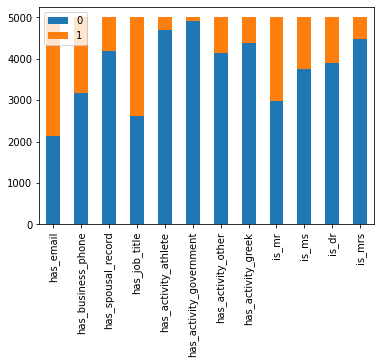

In [502]:
dre_bool_report.T.plot.bar(stacked=True)

Looking at a stacked bar chart of the all boolean columns, it is interesting to note that the incidence of <code>True</code> indicators is on average low. The only two columns that exceed 50% are has_email and has_job_title. In terms of descriptive information to have on a dataset of alumni, these are high value assets. Having a present email address allows the client organization to engage in direct mail campaigns and inform the constituent of engagement opportunities with the client organization. Having a job title would allow further slicing of the database by focusing on senior positions.

### Marital Status

In [503]:
# Exploring the category column marital_status
dre_column = 'marital_status'
print('null count',dre_df[dre_column].isnull().sum())
print('value count',dre_df[dre_column].notnull().sum())
dre_marital_report = dre_df[dre_column].value_counts()
dre_marital_report

null count 35
value count 4965


M    2160
U    1586
S     996
D     110
W     106
E       4
P       2
Z       1
Name: marital_status, dtype: int64

Marital Status has a number of issues that need to be addressed before this feature can be utilized in a statistical model. First among them is the presence of <code>null</code> values. Second, would be determining what the categories indicate. MacDonell has this to say about the provenance of the categories for this column:

> M”, for Married, quite a few are Unknown (U), and almost a thousand are Single (S). “W” and “D” probably stand for Widowed and Divorced. As for the others, your guess is as good as mine.

(2018, MacDonell, pg. 18)

With this information, a general strategy can be formed for cleaning up and imputing this column. The <code>null</code> values, along with <code>E</code>, <code>P</code>, and <code>Z</code> can be reclassified to <code>U</code>.

<AxesSubplot:>

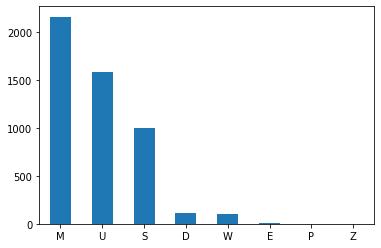

In [504]:
dre_marital_report.plot.bar(x='marital_status',y='count',rot=0)

The majority of constituents are either Married, Unknown, or Single, this indicates that the client organization only comes back into contact with their constituents after they have established themselves. If the client had a direct connection with the registrar of the school they raise funds for, it would be far more likely that the single population would be far higher. This is a good indicator for accuracy in our models as it means it is likely consituents in their database have made an initial connection with them.

### Grad Year

In [505]:
# Exploring the grad_year column
dre_column = 'grad_year'
print('null count',dre_df[dre_column].isnull().sum())
print('value count',dre_df[dre_column].notnull().sum())
print('min val', dre_df[dre_column].min())
print('max val', dre_df[dre_column].max())
dre_grad_report = dre_df[dre_column].value_counts()
dre_grad_report.sort_index(inplace=True)
dre_grad_report

null count 0
value count 5000
min val 1911
max val 2013


1911      1
1930      1
1931      1
1932      1
1934      1
       ... 
2009    135
2010    130
2011    129
2012    103
2013     12
Name: grad_year, Length: 83, dtype: int64

In [506]:
# let's categorize the date by decade to aid in visualization
dre_df['grad_decade'] = pd.cut(x=dre_df['grad_year'],
                           bins=data_dict['dummy']['grad']['bins'],
                           labels=data_dict['dummy']['grad']['labels'],
                           right=False)
dre_column = 'grad_decade'
dre_grad_decade_report = dre_df[dre_column].value_counts()
dre_grad_decade_report.sort_index(inplace=True)
dre_grad_decade_report

1900s       0
1910s       1
1920s       0
1930s      12
1940s      78
1950s     249
1960s     497
1970s     761
1980s     864
1990s    1096
2000s    1068
2010s     374
Name: grad_decade, dtype: int64

Aggregating this column by decade makes the information far easier to parse. However, I am uncertain if this will provide for a stronger or weaker model, so both versions will be tested (binned and unbinned grad_year). In terms of the distribution, ~40% of the constituents have graduated in the past 3 decades, which is typical for post secondary engagement.

<AxesSubplot:>

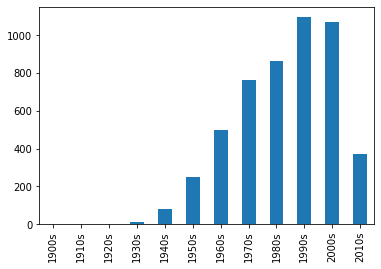

In [507]:
dre_grad_decade_report.plot.bar()

### Cumulative Donation

In [508]:
# Explore the cum_donation column
dre_column = 'cum_donation'
print('null count',dre_df[dre_column].isnull().sum())
print('value count',dre_df[dre_column].notnull().sum())
print('min val', dre_df[dre_column].min())
print('max val', dre_df[dre_column].max())

null count 0
value count 5000
min val 0.0
max val 11187224.58


In [509]:
dre_df['cum_range'] = pd.cut(x=dre_df['cum_donation'],
                             bins=data_dict['dummy']['giving']['bins'],
                             labels=data_dict['dummy']['giving']['labels'],
                             right=False)
dre_column = 'cum_range'
dre_cum_range_report = dre_df[dre_column].value_counts()
dre_cum_range_report.sort_index(inplace=True)
dre_cum_range_report

$0                2555
$1-$999.99        1843
$1K-$9.99K         518
$10K-$24.99K        46
$25K-$49.99K        14
$50K-$99.99K         7
$100K-$249.99K      10
$250K-$499.99K       4
$500K-$999.99K       0
$1M-$2.49M           2
$2.5M-$4.99M         0
$5M-$9.99M           0
$10M-$14.99M         1
Name: cum_range, dtype: int64

Similar to <code>grad_year</code> this information has been binned to aid in visual analysis in addition to providing another avenue for statistical analysis. Cumulative Donations will be modeled in their binned and unbinned states. The size of the bins increase as the magnitude of gift increases. A gift chart as demonstrated above is typical of what is used in practice in the fundraising field. It is constructed in this way to ensure the granularity seen at the lower end of giving is not deviated by larger, more infrequent gifts.

More than half of this dataset are alumni who haven't contributed - yet. From there, the curve of donations decreases steeply. The values hear are unsurprising for higher-ed.

<AxesSubplot:>

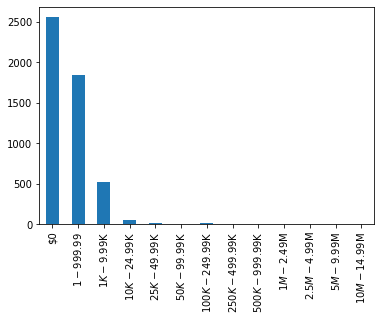

In [510]:
dre_cum_range_report.plot.bar()

## Data-Preparation

### Identifying Significant Features
The identification of significant features has been automatically implemented through the use of Chi-Square values (chi), Random Forest Importances (rfi), Recursive Feature Elimination with Cross Fold Validation (rfecv), and Forward Feature Elimination (ffe). Some of these feature selection algorithms choose features automatically - chi with features greater than 3.8 and rfecv are two such examples. In the instances where features are merely provided a weight with regard to their significance, the values were averaged on only features that exceeded that average were retained.

#### All Models with Feature Selection
Of the 22 models generated by the Automatic Feature Selection stage, 164 features were considered significant, or an average of: 7.45 per model. The most frequently occurring feature across all models is whether two records in the database are associated with a spousal relationship.

<AxesSubplot:>

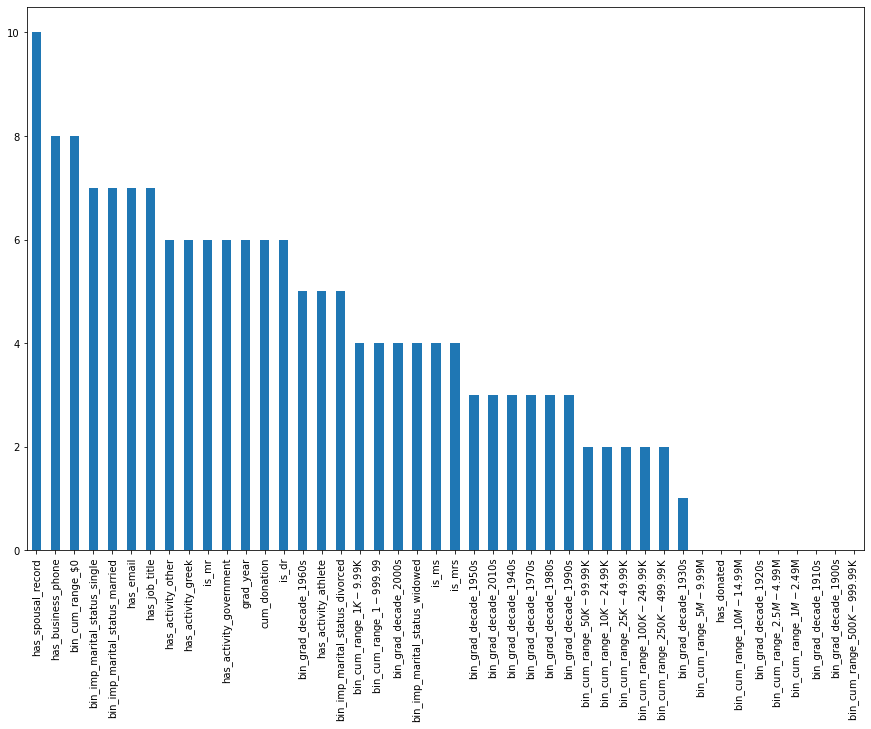

In [511]:
ff_df.T.sum().sort_values(ascending=False).plot.bar(figsize=(15,10))

#### Logistic Models with Feature Selection
Of the 16 models - from Logistic Ancestors, generated by the Automatic Feature Selection stage, 129 features were considered significant, or an average of: 8.06 per model. The feature <code>bin_cum_range_0</code> became the most frequently selected. This is expected somewhat as the response variable <code>has_donated</code> is a derivation of <code>cum_donation</code> which the 0_bin is created from. Since the dataset is comprised of nearly equally split between alumni who have donated something and those who have not, this is likely the reason for its strong association with the classifer.

<AxesSubplot:>

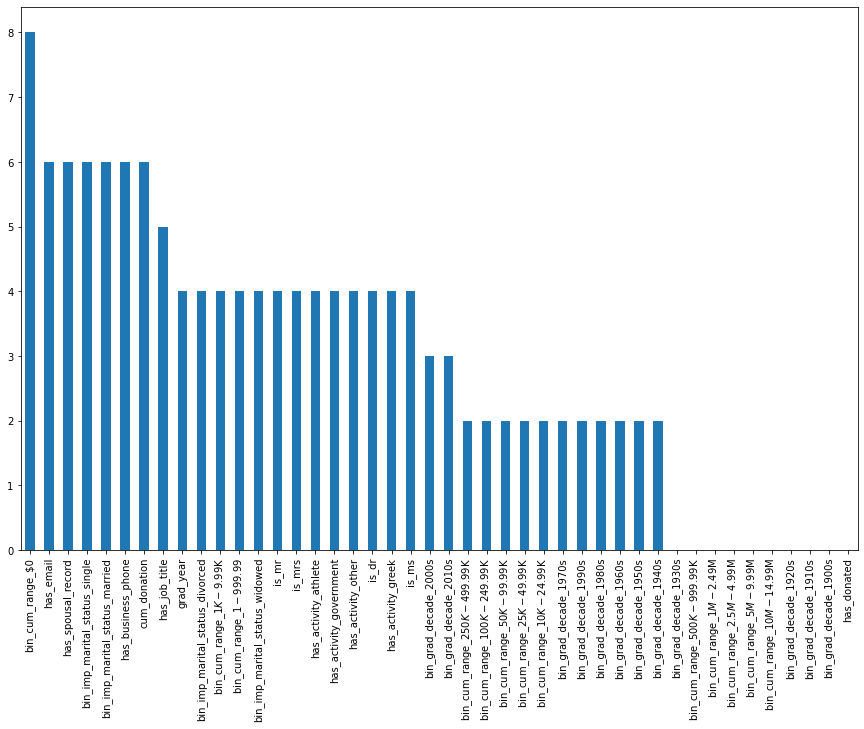

In [512]:
ff_df_log = ff_df.filter(regex='0$')
ff_df_log.T.sum().sort_values(ascending=False).plot.bar(figsize=(15,10))

##### Logistic Models with Binned Variety
When logistic Ancestors are considered in light of their bin arrangement (no bins, only the grad year binned, on the donations binned, and both grad year and donations binned), the feature selection are as follows:

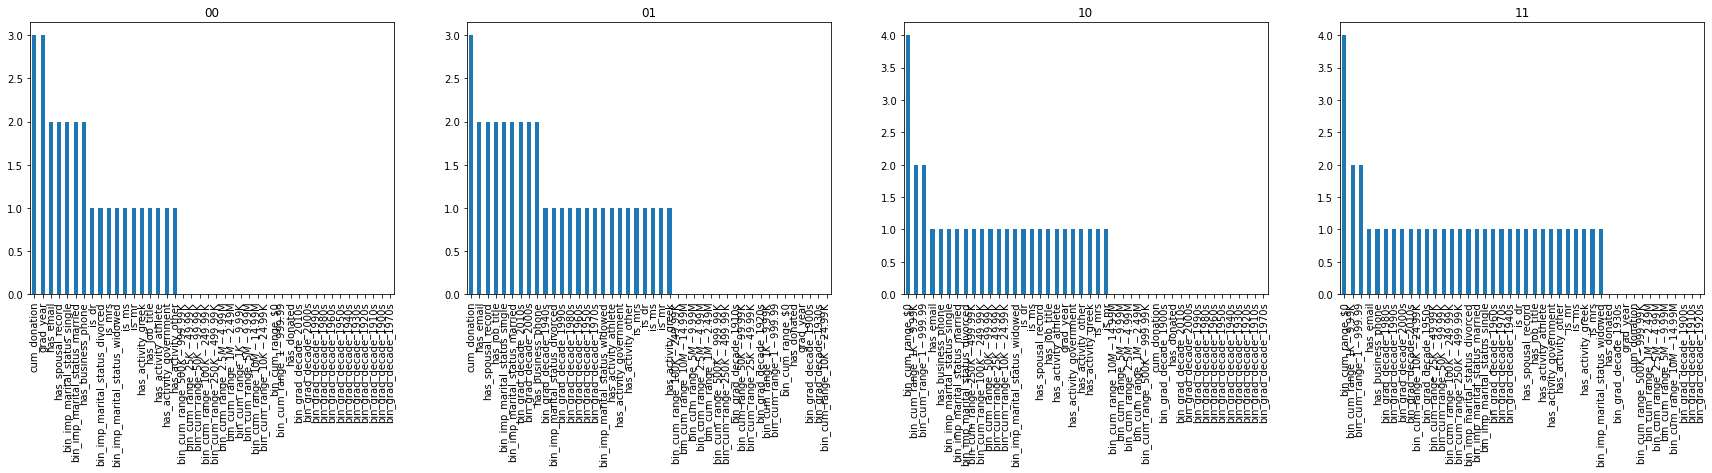

In [513]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(30,5))
bins = ['00','01','10','11']
for bin,ax in zip(bins,axes.ravel()):
    exp =  bin + '0$'
    ff_df.filter(regex=exp).T.sum().sort_values(ascending=False).plot.bar(ax=ax,title=bin)

Having both features binned results in the largest number of features selected in addition to the highest concentration of overlap. Whereas, having neither feature binned results in the fewest selected and a slightly weaker concentration.

#### Linear Models with Feature Selection
Of the 6 models generated by the Automatic Feature Selection stage, 35 features were considered significant, or an average of: 5.83 per model

<AxesSubplot:>

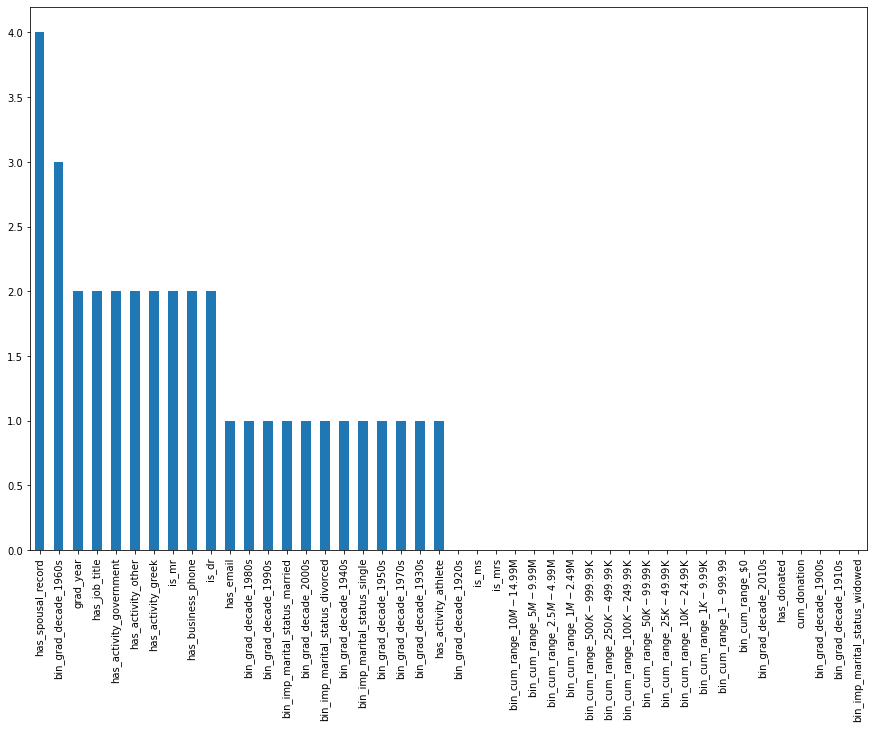

In [514]:
ff_df_lin = ff_df.filter(regex='1$')
ff_df_lin.T.sum().sort_values(ascending=False).plot.bar(figsize=(15,10))

##### Linear Models with Binned Variety


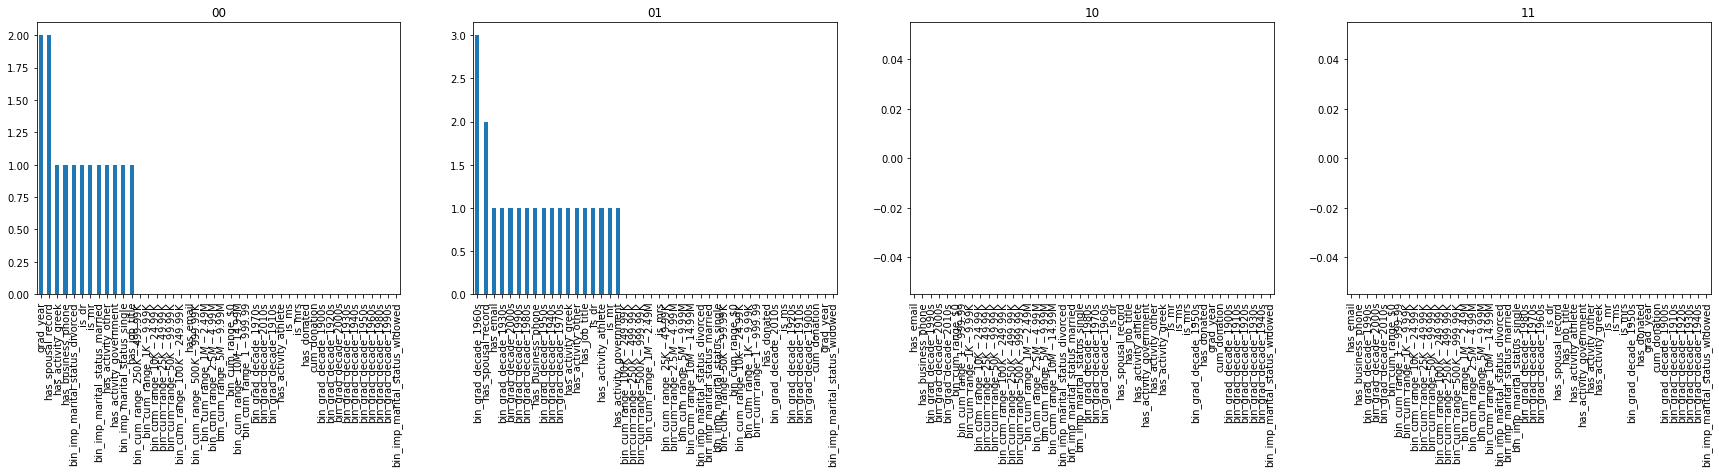

In [515]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(30,5))
bins = ['00','01','10','11']
for bin,ax in zip(bins,axes.ravel()):
    exp =  bin + '1$'
    ff_df.filter(regex=exp).T.sum().sort_values(ascending=False).plot.bar(ax=ax,title=bin)

### Imputing and Variable Creation
#### Imputing
Only one column required imputing - <code>marital_status</code> which went through a number of modifications to prepare it for K Nearest Neighbour imputing, in addition to some clean up processes after the fact. As mentioned earlier in the report, <code>marital_status</code> had a number of issues. It had null values in addition to a number of rows coded with inscrutable information (either through data entry error or lost in meaning due to staff change over). The null values and the categories without a discernable meaning were collapsed into the 'Unknown' category. This category was then imputed to it's 5 nearest neighbours. Values that did not settle directly on a valid category were rounded to their nearest category. A possible improvement to this process may have been to recursively impute the feature until all values settled on a valid category.

#### Variable Creation
A number of variables were also created during the project. Most notably, the <code>has_donated</code> predictor, which - as previously noted in this report - is a boolean mask of the <code>cum_donation</code> where <code>0.00 == 0</code> and <code>0.00 == 1</code>.

#### Binning
Three features were binned: <code>cum_donation</code>, <code>grad_year</code>, and <code>marital_status</code>. <code>marital_status</code> was included as a potential feature (before filtering) in everyone decendent of model. Since <code>cum_donation</code> and <code>grad_year</code> have values that can be scaled to work with the number of binary features a 4 descendant model varieties were produced to analyse how the presence, absensce, and interworking of these binned features would influence the fitness of the models.

## Data Modeling


### Removing invalid models
Through the process of developing logistic and linear models, adding binned and unbinned features, selecting different features through automatic feature selection, scaling, and performing cross validation and stacking - 736 models were created. Obviously, an indepth exploration into each of these models would be unproductive, so a number of them will need to be filtered to identify this projects top models.

#### Models Without Scaling
Models without scaling will be filtered from the population due to a deficiency in the code. Rescaling of predictions was not implemented due to time constraints. Due to this deficiency, unscaled data cannot be confidently compared with scaled data. The population of models will be 552 after this operation.

In [516]:
models_df = models_df[~(models_df['scale']=='none')]


#### Models with only one feature
There are 108 models with only 1 feature considered significant in predicting their response variable. All 1 feature models share a logistic ancestor and are evenly split in containing <code>cum_donation</code> and <code>bin_giving_range_$0</code>. The automatic feature selection used in these models include: RFECV, FFE, and Random Forest Importance in order of descending frequency. I believe these models to be over filtered for their features and will therefore be removed. The population of models will be 444 after this operation.

In [517]:
models_df = models_df[models_df['features']>1]

This trimming process results in an even split between the cross validated models and stacked models. The base models are also proportionate to the distribution of linear and logistic stacked ancestors.

### Stacking
Of the 444 resulting models produced for this project, 378 of them are stacked models. 210 are logistic, the remaining 168 are linear.

#### Determining the Top Stack Logistic Model
Of the 210 Stack Logistic models 154 have perfect scores in accuracy, precision, recall, and f1. These 154 are the result of 35 stacked models.

,bit_str,estimator,model,scale,afs,bins,tar,accuracy,accuracy_sd,precision,precision_sd,recall,recall_sd,f1,f1_sd,features
263,101000110,LogisticRegression(max_iter=500),stack,MinMax,none,both,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,43
264,101000110,DecisionTreeClassifier(),stack,MinMax,none,both,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,43
265,101000110,AdaBoostClassifier(),stack,MinMax,none,both,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,43
266,101000110,RandomForestClassifier(n_estimators=10),stack,MinMax,none,both,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,43
267,101000110,st_LogisticRegression,stack,MinMax,none,both,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,110010000,st_LogisticRegression,stack,Standard,rfi,none,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2
684,111010000,DecisionTreeClassifier(),stack,Robust,rfi,none,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2
685,111010000,AdaBoostClassifier(),stack,Robust,rfi,none,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2
686,111010000,RandomForestClassifier(n_estimators=10),stack,Robust,rfi,none,log,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2


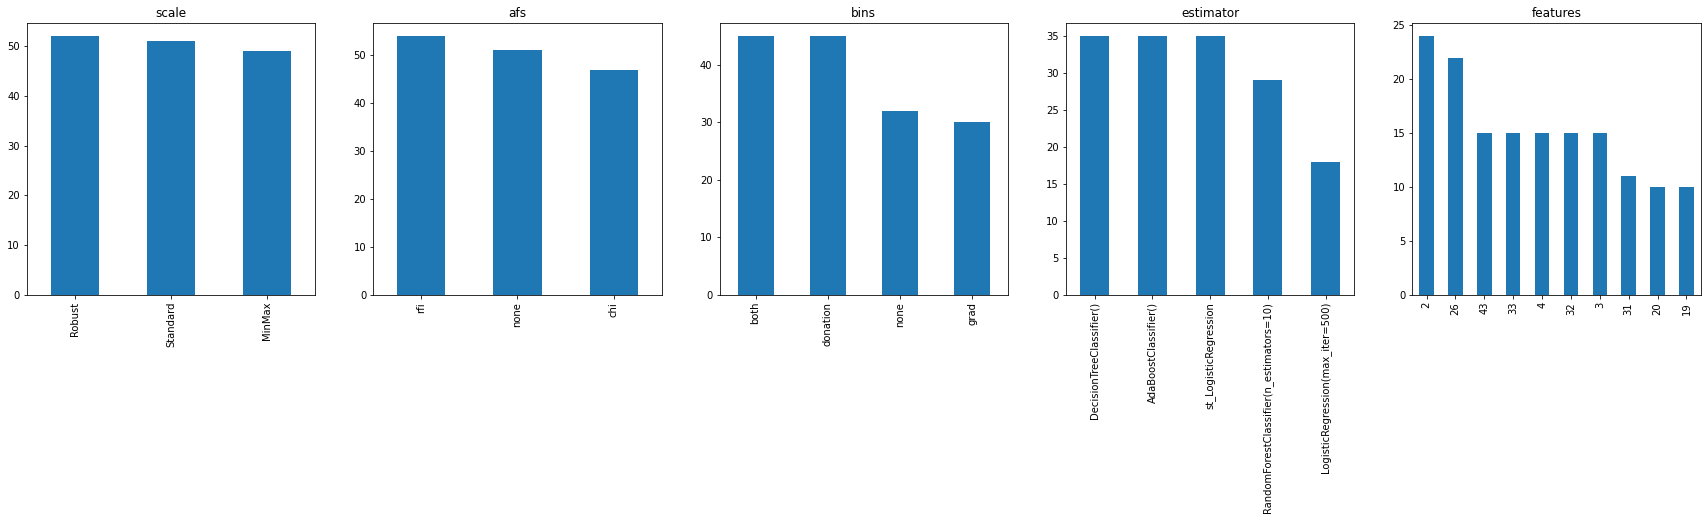

In [518]:
measures_list = ['bit_str','estimator','model','scale','afs','bins','tar',
                 'accuracy','accuracy_sd','precision','precision_sd','recall',
                 'recall_sd','f1','f1_sd','features']

models_df_st_log = models_df[models_df['tar'] == 'log'][measures_list]
models_df_log_top = models_df_st_log[(models_df_st_log['accuracy'] == 1.0) & (models_df_st_log['precision'] == 1.0) & (models_df_st_log['recall'] == 1.0) & (models_df_st_log['f1'] == 1.0)]

fig,axes = plt.subplots(nrows=1,ncols=5,figsize=(30,5))
bins = ['scale','afs','bins','estimator','features']
for bin,ax in zip(bins,axes.ravel()):
    models_df_log_top[bin].value_counts().plot.bar(ax=ax, title=bin)

models_df_log_top

In terms of scale, the Robust Scaler was most commonly present, followed by Standard and then MinMax. In terms of automatic feature scaling, Random Forest Importance was most populous, closely followed by Chi-Square > 3.8 followed by none. Interestingly, both Forward Feature Elimination and Recursive Feature Elimination with Cross Validation were entirely filtered out of this most fit group. There is noticeable differentiation happening with bins, estimators, and features. The both binned and binned donation categories are more populous than none and grad. Additionally, the DecisionTreeClassifier (DTC), AdaBoostClassifier (ABC), and Stacked Model were most populous. Models with 26 features were most represented in this most fit group followed by 2.

Taking this aggregation as an indicator of fitness between similarly perfect scoring models. A Stacked Logistic model with Robust Scaling, Random Forest Importances, both - or only cum_donation - bins, and 26 features arrived at the highest score the most amount of times. Unfortunately, this model cross-section does not exist amongst the 210 considered in this section. However, the stacked model 111001100 satisfies 4 of the 5 discussed features while implementing the Chi Square filtering.

In [519]:
# models_df_log_perf[
#     (models_df_log_perf['scale']=='Robust') &
#     # (models_df_log_perf['afs']=='rfi') &
#     ((models_df_log_perf['bins']=='both') |
#     (models_df_log_perf['bins']=='donation')) &
#     ((models_df_log_perf['estimator']=='DecisionTreeClassifier()') |
#     (models_df_log_perf['estimator']=='AdaBoostClassifier()') |
#     (models_df_log_perf['estimator']=='stack')) &
#     (models_df_log_perf['features']==26)
# ]
log_st_bits = '111001100'

##### Top Stacked Logistic Model: 111001100

In [520]:
models_df[models_df['bit_str']==log_st_bits][['estimator','accuracy',
                                             'accuracy_sd','precision',
                                             'precision_sd','recall',
                                             'recall_sd','f1','f1_sd',
                                             'features']]

,estimator,accuracy,accuracy_sd,precision,precision_sd,recall,recall_sd,f1,f1_sd,features
539,LogisticRegression(max_iter=500),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,26
540,DecisionTreeClassifier(),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,26
541,AdaBoostClassifier(),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,26
542,RandomForestClassifier(n_estimators=10),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,26
543,st_LogisticRegression,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,26


###### Features
The features of the top logistic model are displayed in descending order of chi below. The top three are no mystery. Considering that the logistic target value is derived from <code>cum_donations</code> and the size of the sample is nearly evenly split between $0 and a donation of some value. The next two values follow in a similar logic. As discussed in the previous sections, the most popular gifts are those in the lowest ranges of giving. This is distantly followed by <code>m_marital_status</code> (which denotes whether an marital_status has been imputed or not) and the spousal record.

In [521]:
dict_6bit[log_st_bits[-6:]]['afs'].sort_values('chi',ascending=False)

,feature,chi
15,bin_cum_range_$0,2441.089305
16,bin_cum_range_$1-$999.99,1922.835717
17,bin_cum_range_$1K-$9.99K,540.438905
14,m_marital_status,379.156209
4,has_spousal_record,328.086747
30,bin_imp_marital_status_single,310.604868
2,has_business_phone,166.534897
29,bin_imp_marital_status_married,137.379622
1,has_email,106.012447
13,is_mrs,96.364796


###### ROC Curve
As expected, the ROC Curve for a perfectly scored model is fairly uninteresting.

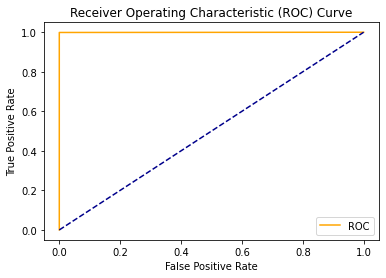

In [522]:
roc_dict = dict_9bit[log_st_bits]['results']['st_LogisticRegression']['roc']

plot_roc_cur(roc_dict['fpr'],roc_dict['tpr'])

###### Measures Interpretation
Perfect scores across accuracy, precision, recall, and f1 means that with the features presented to the model it is capable of perfectly classifying the target variable (given an alumni record without a <code>has_donated column</code>, the model is capable of outputting if that record would have a positive or negative value associated with <code>has_donated</code>).

#### Detemining Top Performing Linear Stacked Model
Of the 168 Linear Stacked Models 5 achieved a RMSE of 0.001 (the lowest value given the values are rounded to 3 places) and a RMSE Standard Deviation of 0.0. The characteristics of these models are graphed below:

,bit_str,estimator,model,scale,afs,bins,tar,rmse,rmse_sd,features
105,101100011,ElasticNet(),stack,MinMax,ffe,grad,lin,0.003,0.0,4.0
107,101100011,DecisionTreeRegressor(),stack,MinMax,ffe,grad,lin,0.003,0.0,4.0
108,101100011,AdaBoostRegressor(),stack,MinMax,ffe,grad,lin,0.003,0.0,4.0
109,101100011,RandomForestRegressor(n_estimators=10),stack,MinMax,ffe,grad,lin,0.003,0.0,4.0
110,101100011,ExtraTreesRegressor(n_estimators=10),stack,MinMax,ffe,grad,lin,0.003,0.0,4.0
111,101100011,st_LinearRegression,stack,MinMax,ffe,grad,lin,0.003,0.0,4.0
137,101000001,ElasticNet(),stack,MinMax,none,none,lin,0.002,0.0,20.0
139,101000001,DecisionTreeRegressor(),stack,MinMax,none,none,lin,0.003,0.0,20.0
140,101000001,AdaBoostRegressor(),stack,MinMax,none,none,lin,0.003,0.0,20.0
141,101000001,RandomForestRegressor(n_estimators=10),stack,MinMax,none,none,lin,0.003,0.0,20.0


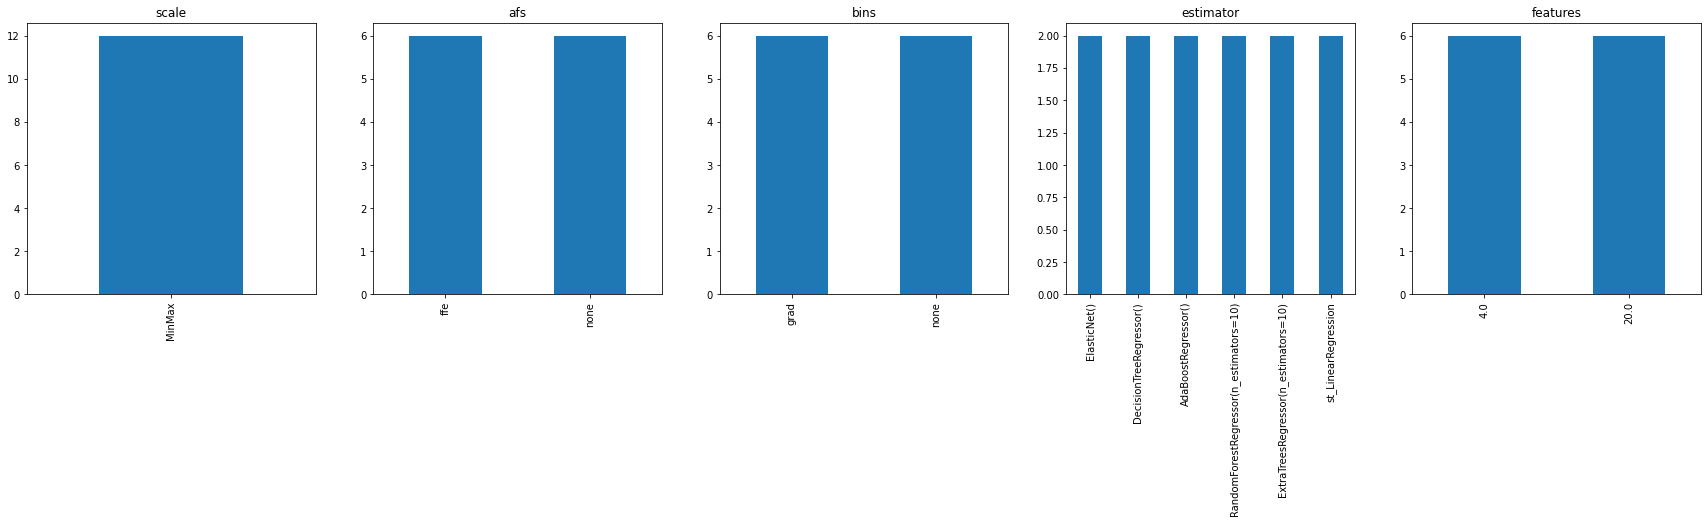

In [545]:
measures_list = ['bit_str','estimator','model','scale','afs','bins','tar',
                 'rmse','rmse_sd','features']

models_df_lin = models_df[models_df['tar'] == 'lin'][measures_list]
models_df_st_lin = models_df_lin[~(models_df_lin['model'] == 'cv')]
models_df_st_lin.sort_values('rmse')
models_df_st_lin_top = models_df_st_lin[models_df_st_lin['rmse']< 0.005]

fig,axes = plt.subplots(nrows=1,ncols=5,figsize=(30,5))
bins = ['scale','afs','bins','estimator','features']
for bin,ax in zip(bins,axes.ravel()):
    models_df_st_lin_top[bin].value_counts().plot.bar(ax=ax, title=bin)

models_df_st_lin_top

As opposed to the stacked logistic models, the stacked linear models have come to a far sharper point. These 5 models intersect on a variety of levels. First, these 5 models are actually two stacked models in addition to a few of their base models that were evaluated as well. The MinMax Scaler and the Random Forest Importance feature filter were ubiquitous among these high scoring models. Interestingly, the linear stacked models preferred the grad bin over no binning, which means that stack models generally prefer binned features to not. In terms of base models, only ElasticNet and AdaBoost succeed in joining their stacked models to the highest score tier. Lastly, 9 features appear to be preferable to 7, but just slightly.

##### Top Stacked Linear Model: 101010011

In [529]:
lin_st_bits = '101010011'

models_df[models_df['bit_str']==lin_st_bits][['estimator','rmse','rmse_sd','features']]

,estimator,rmse,rmse_sd,features
41,ElasticNet(),0.005,0.0,9.0
42,SVR(kernel='linear'),0.021,0.0,9.0
43,DecisionTreeRegressor(),0.005,0.0,9.0
44,AdaBoostRegressor(),0.005,0.0,9.0
45,RandomForestRegressor(n_estimators=10),0.005,0.0,9.0
46,ExtraTreesRegressor(n_estimators=10),0.005,0.0,9.0
47,st_LinearRegression,0.005,0.0,9.0


###### Features
What's interesting here is the divergence between the logistic and linear model in what targets they consider important. Stripped of the donation bins, the logistic model largely targets the same features, but the prioritization is notable. The logistic model does not have a gendered slant, whereas the linear model does. The linear model highly prioritizes athletic activity, which is still selected for in the logistic model but at a lower level of prioritization. It is difficult - and likely foolhardy - to draw too strong a conclusion from the sort order of these features, but it is compelling to consider it.

In [530]:
dict_6bit[lin_st_bits[-6:]]['afs'].sort_values('rfi',ascending=False)

,feature,rfi
5,has_activity_athlete,0.188675
2,has_business_phone,0.151885
9,is_mr,0.132362
21,bin_grad_decade_1960s,0.113430
1,has_email,0.103711
11,is_dr,0.082797
4,has_job_title,0.055925
3,has_spousal_record,0.038014
7,has_activity_other,0.032974


###### Measures Interpretation
The selected top model has an incredibly low and zero RMSE and standard deviation RMSE for the stacked, AdaBoost, and Elasticnet models. This means that it is able to select a value for <code>cum_donation</code> with a high precision of accuracy given the features presented above.

In [531]:
models_df_cv = models_df[models_df['model']=='cv']
models_df_cv_log = models_df_cv[models_df_cv['tar']=='log']
models_df_cv_lin = models_df_cv[models_df_cv['tar']=='lin']

### Cross Fold Validation
Of the 444 resulting models produced for this project, 66 of them are cross validated models. 42 are logistic, the remaining 24 are linear.

#### Determining the Top CV Logistic Model
Of the 42 Cross Validated Logistic models 13 have perfect accuracy, precision, and f1 in addition to near perfect recall.

,bit_str,estimator,model,scale,afs,bins,tar,accuracy,accuracy_sd,precision,precision_sd,recall,recall_sd,f1,f1_sd,features
262,001000110,cv,cv,MinMax,none,both,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,43
268,010000110,cv,cv,Standard,none,both,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,43
274,011000110,cv,cv,Robust,none,both,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,43
286,001001110,cv,cv,MinMax,chi,both,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,33
292,010001110,cv,cv,Standard,chi,both,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,33
322,011010110,cv,cv,Robust,rfi,both,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,4
508,010000100,cv,cv,Standard,none,donation,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,32
514,011000100,cv,cv,Robust,none,donation,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,32
526,001001100,cv,cv,MinMax,chi,donation,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,26
532,010001100,cv,cv,Standard,chi,donation,log,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,26


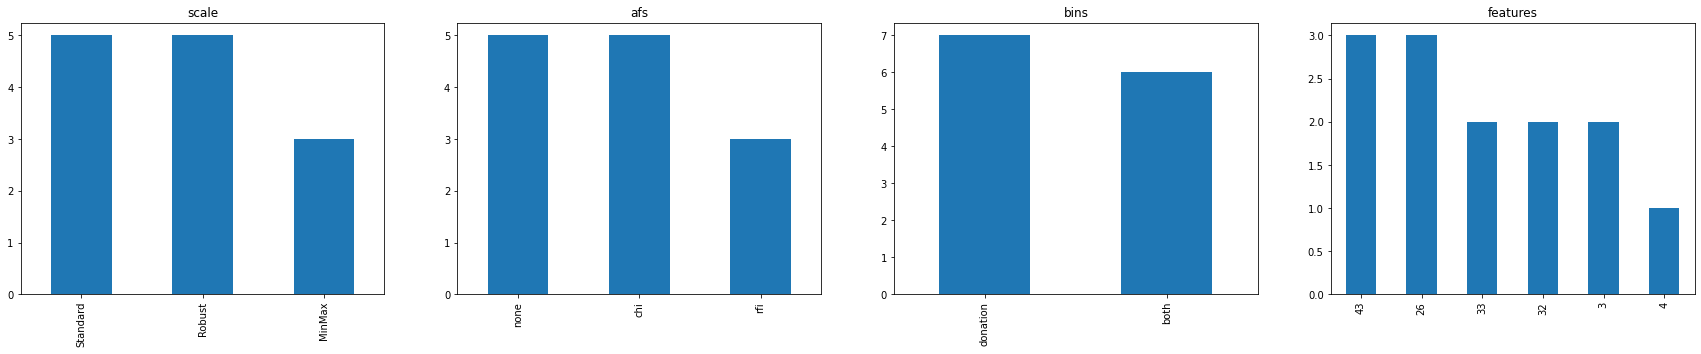

In [532]:
measures_list = ['bit_str','estimator','model','scale','afs','bins','tar',
                 'accuracy','accuracy_sd','precision','precision_sd','recall',
                 'recall_sd','f1','f1_sd','features']

models_df_cv_log = models_df_cv_log[measures_list]
models_df_cv_log_top = models_df_cv_log[(models_df_cv_log['accuracy'] == 1.0) & (models_df_cv_log['f1_sd'] == 0.0)]

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(30,5))
bins = ['scale','afs','bins','features']
for bin,ax in zip(bins,axes.ravel()):
    models_df_cv_log_top[bin].value_counts().plot.bar(ax=ax, title=bin)

models_df_cv_log_top

In Aggregate, the Cross Validated Logistic Model shows a slight, but clear preference for models with Standard Scaling, Chi-Square filtering, having the donations binned, and including 26 features.

In [533]:
# models_df_cv_log_perf[
#     (models_df_cv_log_perf['scale']=='Standard') &
#     (models_df_cv_log_perf['afs']=='chi') &
#     (models_df_cv_log_perf['bins']=='donation') &
#     (models_df_cv_log_perf['features']==26)
# ]
log_cv_bits = '010001100'

##### Top Cross Validated Logistic Model: 010001100

In [534]:
models_df[models_df['bit_str']==log_cv_bits][['estimator','accuracy',
                                             'accuracy_sd','precision',
                                             'precision_sd','recall',
                                             'recall_sd','f1','f1_sd',
                                             'features']]

,estimator,accuracy,accuracy_sd,precision,precision_sd,recall,recall_sd,f1,f1_sd,features
532,cv,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,26


###### Features
An interesting development is that that top performing Stacked logistic model and the top performing Cross Validated logistic model share the same ancestor in terms of feature selection. As such, the discussion that took place regarding the stacked model logistic feature set applies here.

In [535]:
dict_6bit[log_cv_bits[-6:]]['afs'].sort_values('chi',ascending=False)

,feature,chi
15,bin_cum_range_$0,2441.089305
16,bin_cum_range_$1-$999.99,1922.835717
17,bin_cum_range_$1K-$9.99K,540.438905
14,m_marital_status,379.156209
4,has_spousal_record,328.086747
30,bin_imp_marital_status_single,310.604868
2,has_business_phone,166.534897
29,bin_imp_marital_status_married,137.379622
1,has_email,106.012447
13,is_mrs,96.364796


###### Feature Relationship to the target
Cross Validation makes accessing the coefficients of the model exceptionally smooth. Additionally, some newer features in Pandas 1.1.0 makes sorting by absolute value, equally easy. The three features with the strongest impact on the model are <code>bin_cum_range_$0</code> (which has the strongest impact and is negatively correlated), <code>bin_cum_range_$1-$999.99</code> (which is positively correlated), and <code>bin_cum_range_$1K-$9.99K</code> (which is positively correlated). In relation to the dataset, negative corellation would indicate the presence of this feature predisposes the target to be negative while the opposite is true.

This analysis also puts a fine point on a fundamental issue with all of the logistic models regardless of their cross validation or stacking: co-linearity. The bin of cumulative donation trends exactly with <code>has_donated</code> and pollutes the result. It is because of this, the top model will almost certainly be a linear one.

In [536]:
coef_df_cv_log = dict_9bit[log_cv_bits]['results']['cv']['coef'].sort_values('coef',ascending=False,key=abs)
coef_df_cv_log

,feature,coef
14,bin_cum_range_$0,-3.925968
15,bin_cum_range_$1-$999.99,2.704882
16,bin_cum_range_$1K-$9.99K,1.543818
8,has_activity_greek,0.598701
17,bin_cum_range_$10K-$24.99K,0.460183
18,bin_cum_range_$25K-$49.99K,0.244104
20,bin_cum_range_$100K-$249.99K,0.204120
0,has_email,0.203086
3,has_spousal_record,0.188530
19,bin_cum_range_$50K-$99.99K,0.175378


###### ROC Curve
As expected, the ROC Curve for a perfectly scored model is fairly uninteresting.

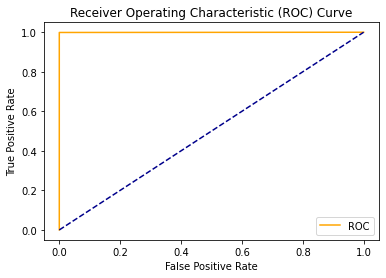

In [537]:
roc_dict = dict_9bit[log_st_bits]['results']['st_LogisticRegression']['roc']

plot_roc_cur(roc_dict['fpr'],roc_dict['tpr'])

###### Measures Interpretation
Perfect scores across accuracy, precision, recall, and f1 means that with the features presented to the model it is capable of perfectly classifying the target variable (given an alumni record without a <code>has_donated column</code>, the model is capable of outputting if that record would have a positive or negative value associated with <code>has_donated</code>).

#### Determining the Top CV Logistic Model
As opposed to the other model families, the Cross Validation Logistic models (of which there are 24) have a clear winner: 001010001. This top performing model has the MinMax scaler, Random Forest Importance and selects neither of the binned features. It also has 7 features.

In [538]:
measures_list = ['bit_str','estimator','model','scale','afs','bins','tar',
                 'rmse','rmse_sd','features']

models_df_cv_lin = models_df_cv_lin[measures_list]
models_df_cv_lin_top = models_df_cv_lin[models_df_cv_lin['rmse']<0.01]

# fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(30,5))
# bins = ['scale','afs','bins','features']
# for bin,ax in zip(bins,axes.ravel()):
#     models_df_cv_lin_top[bin].value_counts().plot.bar(ax=ax,title=bin)

lin_cv_bits = '001010001'

models_df_cv_lin_top

,bit_str,estimator,model,scale,afs,bins,tar,rmse,rmse_sd,features


###### Features
The features selected for this model are similar to the features selected for the stacked linear model. In that they are interested in the biographical features most related to gender, marital status, and school volunteerism.

In [539]:
dict_6bit[lin_cv_bits[-6:]]['afs'].sort_values('rfi',ascending=False)

,feature,rfi
10,is_mr,0.206985
3,grad_year,0.161969
2,has_business_phone,0.145047
12,is_dr,0.082686
8,has_activity_other,0.078745
5,has_job_title,0.071720
4,has_spousal_record,0.053889


###### Feature Relationship to the target
The features for the Cross Validated linear model weakly act on the target variable. The strongest relationship is whether the alumni has a spousal record.

In [540]:
coef_df_cv_lin = dict_9bit[lin_cv_bits]['results']['cv']['coef'].sort_values('coef',ascending=False,key=abs)
coef_df_cv_lin

,feature,coef
6,has_spousal_record,0.001500
0,is_mr,0.000770
1,grad_year,-0.000672
2,has_business_phone,0.000392
4,has_activity_other,-0.000201
3,is_dr,0.000192
5,has_job_title,0.000187


## Model Evaluation
As a result of this project, there are four potential models to choose from in selecting the best model to represent this data. This includes the two logistic models:

In [541]:
models_df[((models_df['bit_str']==log_st_bits) & (models_df.estimator.str.contains('st_'))) | (models_df['bit_str']==log_cv_bits)]

,bit_str,estimator,model,scale,afs,bins,tar,rmse,rmse_sd,accuracy,accuracy_sd,precision,precision_sd,recall,recall_sd,f1,f1_sd,features,roc,coef
532,010001100,cv,cv,Standard,chi,donation,log,NaN,NaN,1.0,0.0,1.0,0.0,0.999,0.001,1.0,0.0,26,NaN,feature coef ...
543,111001100,st_LogisticRegression,stack,Robust,chi,donation,log,NaN,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,26,"{'fpr': [0.0, 0.0, 1.0], 'tpr': [0.0, 0.998839...",NaN


And the two linear models:

In [542]:
models_df[((models_df['bit_str']==lin_st_bits) & (models_df.estimator.str.contains('st_'))) | (models_df['bit_str']==lin_cv_bits)]

,bit_str,estimator,model,scale,afs,bins,tar,rmse,rmse_sd,accuracy,accuracy_sd,precision,precision_sd,recall,recall_sd,f1,f1_sd,features,roc,coef
47,101010011,st_LinearRegression,stack,MinMax,rfi,grad,lin,0.005,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN
168,001010001,cv,cv,MinMax,rfi,none,lin,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,feature coef 0 ...


The final selection will be from among the linear models due to the co-linearity issues identified in the logistic ancestors, and from among the linear model the Cross Validated model is more appealing. Throughout the analysis phase of this project, I was immediately suspicious of the high scoring nature of the stacked models. There appeared to be something virtual about those scores that the Cross Validated values lacked. As such, even though the Cross Validated model has slightly lower RMSE and greater Standard Deviation, it is preferable. Additionally, the usage of a linear estimator through this process of developing this models allows us to interrogate the model's coefficients (that while weak, still gives us some insight into how this model operates under the hood).

### Improvement
1. A proper implementation of rescaling data would be helpful in comparing models that did not undergo scaling to those that did. 184 models were stripped from the project due to this deficiency.
2. Adding in logic to reduce co-linearity. The logistic models clearly suffer from co-linearity, due to the inclusion of binned donation along with the donation response variable. Removing these features and seeing how the models respond would be useful.

## Conclusion
This project is large. Far larger than I intended it to be when I set out to complete it. However, it has been massively instructive in the modeling process and provides good lessons for future modeling projects.

### Lessons
#### Do Not overwork the model
I developed 700+ models for this project. The biggest revelation I had as a result of this is that a modeler does not need to do that much work to come to a decent result. Many of the models I produced were redundant. A more careful interrogation of the predictive modeling lifecycle could have avoided many of these. Just as I exempted the inclusion of cum_donation bins from the linear models out of fear of co-linearity, I should have done the same for the logistic models. This would have halved the number of models created.

#### Do Not Split up the Predictive Modelling Process
The way I conceptualized my program was to handle each stage of the predictive modelling journey in discrete steps: cleaning, binning, feature filtering, scaling, and modeling. There is nothing wrong with this conceptually, but the way I structured by program led to a number of issues.

Rather than structuring my program with a main method that calls cleaning, binning, feature filtering, etc. in the course of its execution, each stage in the journey passed their data to the next in dict structures. This makes my code far less readable and reusable.

The one section of this program that I am particulary proud of would be the feature filtering section as this follows this main method and function structure.

#### Do Not use a bit word to describe a model
One of the features I implemented in my program was to tag every model with an iteratively built bit word as it progressed through the modeling journey. My thought was that this would allow me to see the characteristics of the model at a glance. Although this worked, I believe the solution is largely pretentious. What information could have be stored in a bit word could have just as easily been stored in an object with property accessors. The use of classes and object would have increased the portability and reusability of this code.

### Proud Points
I'm exceptionally proud of the amount of work on display here. Even though this assignment is three days late, I feel it is worthy of a capstone project. Rather than feeling closed off by this uneven modeling experience, I am enthused to undertake this work again and continue to improve as a data analyst.